# Bank Customer Churn Prediction


## Contents
* [Part 1: Exploratory Data Analysis](#Part-1:-Data-Exploration)
* [Part 2: Data Preprocessing](#Part-2:-Data-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Conclusions and Future Improvements](#Part-4:-Conclusions-and-Future-Improvements)

# Part 1: Data Exploration

In [115]:
# for data exploration
import pandas as pd
import numpy as np

# for ploting 
import matplotlib.pyplot as plt
import seaborn as sns

# remove warnings 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

print('✔️ Libraries Imported!')

✔️ Libraries Imported!


In [116]:
font_size = 15
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#f1a340', '#998ec3']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Parameters and Variables Set!')

✔️ Default Parameters and Variables Set!


### 1.1 Understand the Raw Dataset

In [117]:
churn_df = pd.read_csv('bank_churn.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [118]:
# check the feature numbers
print(f'Dataset contains {churn_df.shape[0]} rows and {churn_df.shape[1]} columns.')

Dataset contains 10000 rows and 14 columns.


### 1.2  Understand the features

In [119]:
# 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped
to_drop = ['RowNumber','CustomerId','Surname']
df = churn_df.drop(to_drop, axis=1)

In [120]:
# check missing values
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [121]:
# understand Numerical feature
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


**Analysis for the describtion of numerical features:**
1. The age of customrs ranges from 18 to 91, with a mean value approximately equal to 40.
2. The mean tenure is 5, so if define __*loyal*__ as having a tenure above 3 years, the majority are loyal.
3. Approximately 50% of customers are active, 20% have exite.
4. The EstimatedSalary has a range from $11.58$ to $199,992.48$, with the first quantil being $51,002.11$. It could be that some input of salary are hourly calculated, need to be confirmed with other departement who gathered the data.
5. Luckily, there's no missing value of this dataset.

### 1.3  Creating a Test Set

EDA will help us understand our dataset better. However, in order to protect models from __*data leakage*__,  normally I would _not_ use a preprocssing method that is fitted on the whole dataset, to transform the test set or train data. Therefore, apply the train_test_split here.

In [122]:
y=df['Exited']
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42,stratify = y)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Train set: {train_df.shape[0]} rows x {train_df.shape[1]} columns')
print(f'Test set: {test_df.shape[0]} rows x {test_df.shape[1]} columns')

Train set: 8000 rows x 11 columns
Test set: 2000 rows x 11 columns


### 1.4  Exploratory Data Analysis

#### 1.4.1 Target Variable Exploration

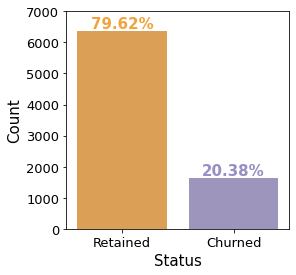

In [123]:
# count plot for target variable 
fig, ax = plt.subplots (figsize=(4, 4)) 

sns.countplot(x='Exited', data=train_df, palette=colors, ax=ax)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label= f"{value/train_df['Exited'].shape[0]*100 :.2f}%"
    ax.annotate(label,
                xy=(index, value + 250),
                ha='center',
                va='center',
                color=colors[index],
                fontweight='bold',
                size=font_size )


ax.set_xticklabels(['Retained', 'Churned'])
ax.set_xlabel('Status')
ax.set_ylabel('Count')
ax.set_ylim([0, 7000]);       


**Analysis for the target variable:**

The bank has kept around 80% of its client. Yet the target variable itself is __*skewed*__ since the number of instances class as `Retained` outnumbered the `Churned`. Therefore, accuracy is not the most appropriate metric of model performance measurement. 

#### 1.4.2 Continuous Variables Exploration

In [124]:
# seperate continuous and categorical variables 
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous:' ,  ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))


Continuous: Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'CreditScore'}>],
       [<AxesSubplot:title={'center':'Balance'}>,
        <AxesSubplot:title={'center':'EstimatedSalary'}>]], dtype=object)

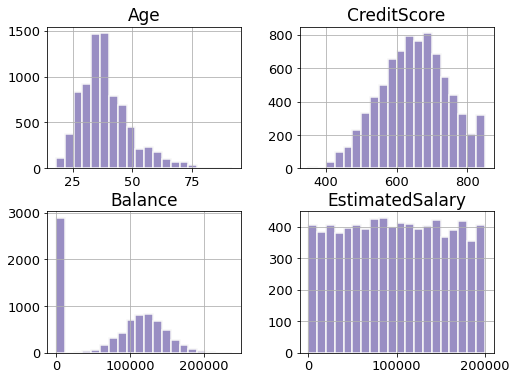

In [125]:
# hist plot for numeric variables 
train_df[continuous].hist(figsize=(8, 6),
                          bins=20,
                          layout=(2, 2),
                          color='#998ec3',
                          edgecolor='#f7f7f7',
                          linewidth=1.5)

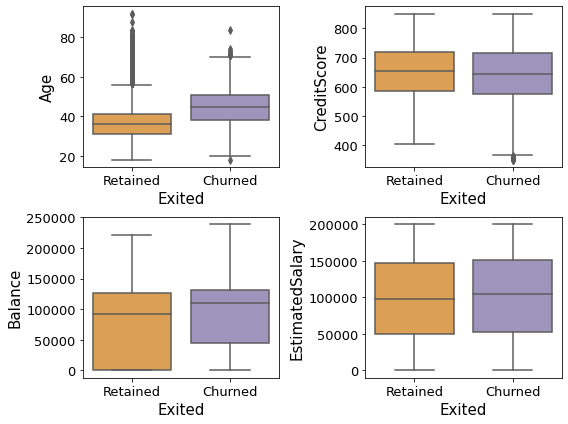

In [126]:
# boxplot for numerical variables 
df_cont=train_df[continuous]

fig, ax = plt.subplots(2,2,figsize= (8,6))

for index, column in enumerate(df_cont.columns):
    # plot for each index accoring to the place in the chart
    plt.subplot(2,2,index+1)
    sns.boxplot(x='Exited',y= column, data = train_df, palette=colors)
    plt.xticks([0,1],['Retained','Churned'])
    

plt.tight_layout()

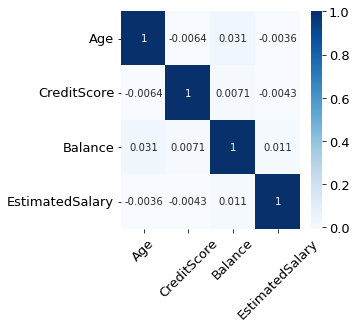

In [127]:
# check for the correlation of variables 
fig, ax = plt.subplots(figsize=(4, 4))

sns.heatmap(train_df[continuous].corr(),
            annot=True,
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

**Analysis for the numeric variables:**

1. The histgram shows:
- Age is slightly skewed, and has different distribution in regard to the target variable. 
- Except for the first bin of Balance, `Balance` and `CreditScore` shows normal pattern of distribution.
- Yet the distribution of `EstimatedSalary` is somewhat uniformed and provides little information.
2. The box plot shows:
- There's clear difference between age groups, that older people are more likely to churn. This observation could potentially indicate that preferences change with age, and _the bank hasn't adapted its strategy to meet the requirements of older customers_.
- The distribution of Balance are quite similar, yet there's a big percentage of non-churned customers with a low account balance. 
3. There's no significant intercorrelation between numerical features, therefore no need to worry about multicollinearity. 

#### 1.4.3 Categorical Variables Exploration

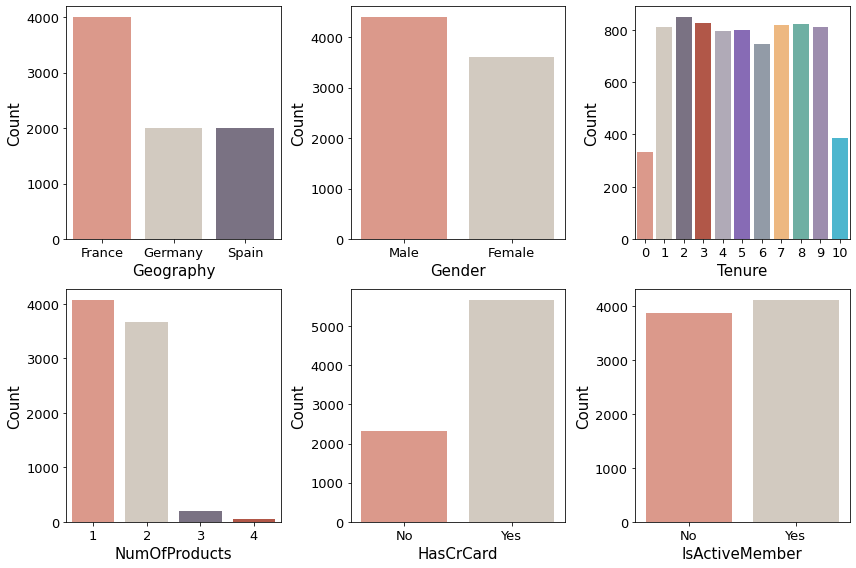

In [128]:
# count plot for all categorical variables
df_cat = train_df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns): 
    plt.subplot(2,3,index+1) # plot for the current index
    sns.countplot(x=column, data=train_df, palette=colors_cat)
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0,1],['No','Yes'])

plt.tight_layout()

**Analysis for the categorical variables:**

1. The count plot shows:
- The bank has customers in three countries: France, Spain, and Germany, where France has the most customers. 
- Only a small percentage leaves within the first year, and the count of customers in tenure years between 1 and 9 is almost the same. 
- The majority of customers purchased products of 1 or 2. 
- A significant majority of customers has a credit card, and
almost 50% of customers are not active.

In [129]:
def plot_categorical(feature):
    """
    For each categorical feature, plot:
    1. A seaborn.count plot for the total count of each category.
    2. A barplot for the churn rate.
    """
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

    sns.countplot(x = feature,
                  hue = 'Exited',
                  data = train_df,
                  palette = colors,
                  ax = ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained','Churned'])

    # the barplot shows the mean value 
    sns.barplot(x = feature,
                y = 'Exited',
                data = train_df,
                palette = colors_cat,
                ax = ax2)
    ax2.set_ylabel('Churn Rate')
    
    plt.tight_layout()

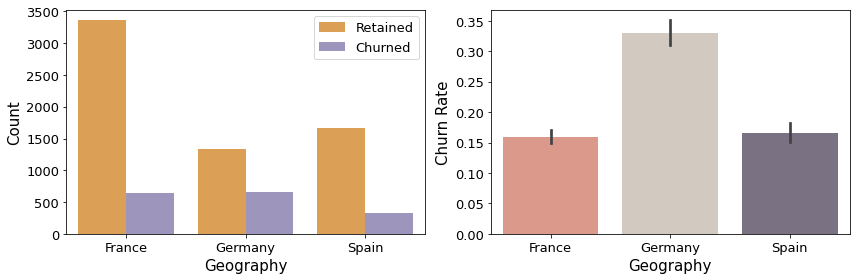

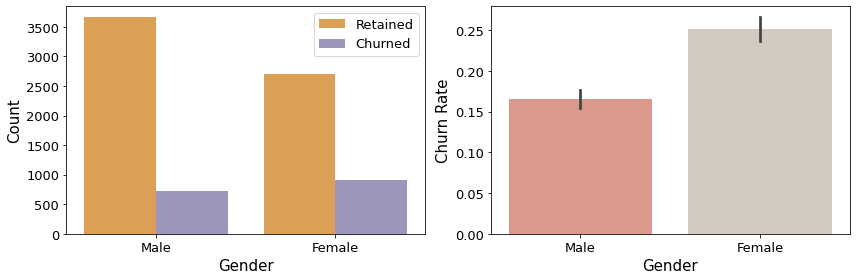

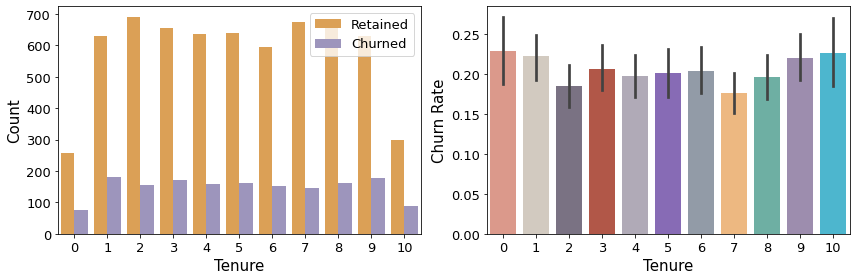

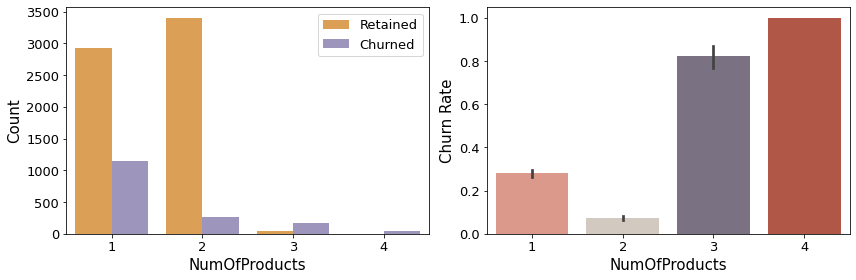

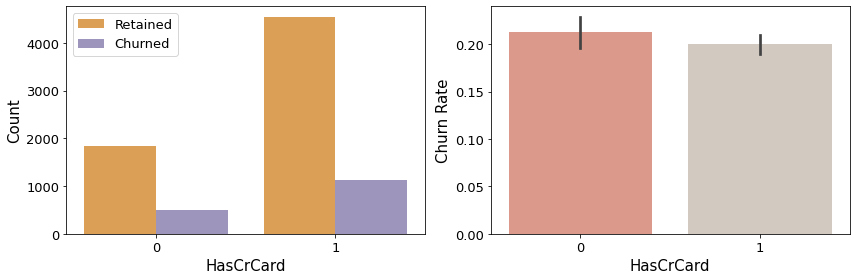

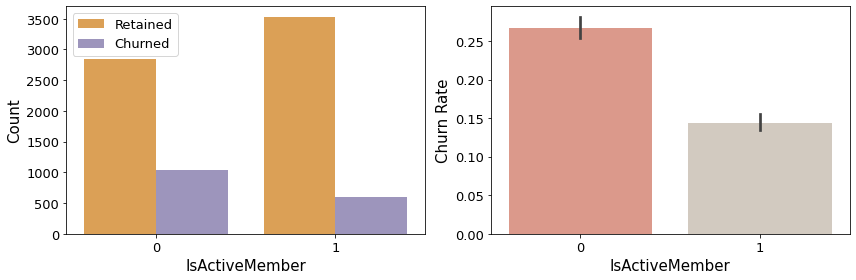

In [130]:
# draw the count and bar plot for each categorical feature with greater details
for i in range(len(categorical)):
    plot_categorical(train_df[categorical].iloc[:,i])

**Analysis for the categorical variables:**

2. The count and bar plot shows:
- Customers in `Germany` are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France). Many reasons could explain this finding, such as higher competition or different preferences for German customers.
- Femal customers are more likely to churn.
- The number of years (tenure), and having a credit card does not seem to affect the churn rate.
- Counterintuitively, havig 3 or more products _increase_ the likelyhood of churn. It could be that the bank are not competent in supporting customer service when there's more product, and therefore generate the customer dissatisfaction. 
- It's not surprising that inactive customers are more likely to churn. 

# Part 2: Data Preprocessing

### 2.1  Feature Selection
I'd already perfromed partly of the feature selection by dropping columns like of `RowNumber`, `CustomerId`, and `Surname` at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:
- `EstimatedSalary` displays a uniform distribution for both types of customers and can be dropped.
- The categories in `Tenure` and `HasCrCard` have a similar churn rate and are deemed redundant. This can also be confirmed from a following chi-square test ([Reference](https://towardsdatascience.com/gentle-introduction-to-chi-square-test-for-independence-7182a7414a95))

In [131]:
chi2_array, p_array = [],[]

for column in categorical:
    # crosstab returns the frequency table of the factors
    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({
    'Variable':categorical,
    'Chi-square':chi2_array,
    'p-value':p_array
})
df_chi.sort_values(by = 'Chi-square', ascending = False)

,Variable,Chi-square,p-value
3,NumOfProducts,1209.196262,7.411655e-262
0,Geography,266.055862,1.685402e-58
5,IsActiveMember,184.773456,4.397994e-42
1,Gender,89.224504,3.524562e-21
2,Tenure,11.602543,3.125368e-01
4,HasCrCard,1.609027,2.046287e-01


`Tenure` and `HasCrCard` have a small chi-square and a p-value greater than 5% (the standard cut-off value), confirming our initial hypothesis that these two features do not convey any useful information.

In [132]:
# remove the above three features by droping from training set
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df = train_df.drop(features_drop, axis=1)

### 2.2 Encoding Categorical Features 

The dataset includes two features that require encoding:
- For `Gender`, I will use scikit-learn's LabelEncoder() which maps each unique label to an integer (Male --> 1 and Female --> 0).
- For `Geography`, there's two possible way of encoding it：
    - One-Hot-Encoding: using __*get_dummies()*__, yet the newly added features for France and Spain have small feature importance. Therefore I would go for the second method.
    - Manually map values: since we'd already observed from the EDA that the churn rate in Germany is much higher than the two other countires, whom are almost equal and considerably low. Therefore it makes sense to encode this feature to differentiate between German and non-German customers. 

In [133]:
# feature encoding 
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0})

In [134]:
train_df.head()


,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,IsActiveMember,Exited
0,753,0,1,57,0.00,1,0,1
1,739,1,1,32,102128.27,1,0,1
2,755,1,0,37,113865.23,2,1,0
3,561,0,1,37,0.00,2,0,0
4,692,1,1,49,110540.43,2,1,0


In [135]:
train_df['CreditScore'].dtype

dtype('int64')

### 2.3 Scaling 

As a technique for normalize the range of features, scaling is especially important for some algorithms that are sensitive to it (e.g. SVM, Neural Network), while others are invariant (e.g. Random Forests).

[Scikit Learn Preprocessing Doc](https://scikit-learn.org/stable/modules/preprocessing.html)

In [136]:
# use StandardScaler for scaling

scaler = StandardScaler()
scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

In [137]:
# split the train and set into X_train and y_train sets

X_train = train_df.drop('Exited', axis =1 )
y_train = train_df['Exited']

### 2.4 Addressing Class Imbalance 

As we'd previously seen, there's an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned). <br><br>
Classification using imbalanced dada would be biased in favor of majority classes, and common metrics like accuracy can be misleading when handling it. <br><br>
I'm using SMOTE (Synthetic Minority Oversampling Technique) strategy, which will 
> finds a record that is similar to the record being upsampled and creates a synthetic record that is a randomly weighted average of the original record and the neighbouring record, where the weight is generated separately for each predictor 

and inshort, oversample the minority.

In [138]:
y_train.value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

In [139]:
smote = SMOTE(sampling_strategy= 'auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()

1    6370
0    6370
Name: Exited, dtype: int64

# Part 3: Model Training and Result Evaluation

### 3.1 Building Up Baseline Models
First creating two simple models to estimate the baseline performance on the training set. Specifically, I will use Gaussian Naïve Bayes and Logistic Regression, with default parameters and evaluate their (mean) recall by performing k-fold cross-validation.


In [140]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=42))]

cv_base_mean, cv_std = [],[]
for clf in clf_list:
    cv = cross_val_score(estimator = clf[1],
                         X = X_train,
                         y = y_train,
                         scoring = scoring_metric,
                         cv = 5)          

    cv_base_mean.append(cv.mean())  
    cv_std.append(cv.std())   

print ('Baseline Model Performance (Recall):\n'
        '-------------------------------------')

for i in range(len(clf_list)):
    [print(f'{clf_list[i][0]}:{np.round(cv_base_mean[i],2)}')]

Baseline Model Performance (Recall):
-------------------------------------
Gaussian Naive Bayes:0.71
Logistic Regression:0.7


### 3.2 Model Tuning

As being ready for the model tuning, the five classifier I have selected are the following:

1. K Nerarest Neighbours Classifier
2. Logistic Regression
3. Support Vector Classifier
4. Random Forest Classifier
5. Gradient Boosting Classifier 
6. Ensemble Classifier

For the hyperparameter tuning that finding the set of values that optimal the model performance, I will utilize `GridSearchCV` with the hyperparameters that I'd like to experiment on, which will then evaluate all the possible combinations of values. Note that GridSearchCV evaluates performance by performing k-fold cross-validation (therefore, a number of folds, cv, needs to be provided).<br><br>

As mentioned eariler, a plot of the [learning curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)([understanding](https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5)) will also be provided for each classifier other than the [confusion matrix](https://www.knime.com/blog/from-modeling-to-scoring-confusion-matrix-and-class-statistics). Learning curves are plots of a model's performance on the training set and the validation set as a function of the training set size. They can help us visualise overfitting/underfitting and the effect of the training size on a model's error.



In [141]:
def plot_conf_mx(cm, ax):
    """
    Plot a confusion matrix in the speified axed object. 
    """
    from sklearn.metrics import confusion_matrix
    
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentage = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for
                 v1,v2,v3 in zip(group_names, group_counts, group_percentage)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(data = cm, # get the percentage of data is represented in each quadrant
                annot = labels,
                fmt = '',
                cmap = 'Blues',
                annot_kws = {'fontsize':20},
                ax = ax)
    ax.set_xlabel('Predicted Label')
    # set the x axis' tick locations and optional labels
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained','Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned'])

In [142]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        # -1: automatically use all of the cores in my system
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14)
    

In [143]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    """
    Display the confusion matrix and the learning curve for the classification model.
    """
    print('\n', classifier_name)
    print('-------------------------------')
    print(f'   Best Score ({scoring_metric}):  {str(np.round(classifier.best_score_, 3))}')
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print(      f'{key}: {value}')

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred) #, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout()

#### K Nearest Neighbors

The result bolow shows that grid search has decided 1-Nearest Neighbor, which is the most complex nearest neighbor model to be the best, and the optimal distance method is Mahattan or p = 1. This would introduce low bias (brings the prediction closer to the training data), with a high variance (highly dependent on this batch of training set).<br><br>

The learning curve also shows this overfitting pattern with a very high and consistnet training score, and the cross validation score increases upon adding training examples and *doesn't flatten*, indicating addition of more training examples can improve the model performance on unseen data.


 K Nearest Neighbours
-------------------------------
   Best Score (recall):  0.866
   Best Parameters: 
n_neighbors: 1
p: 1


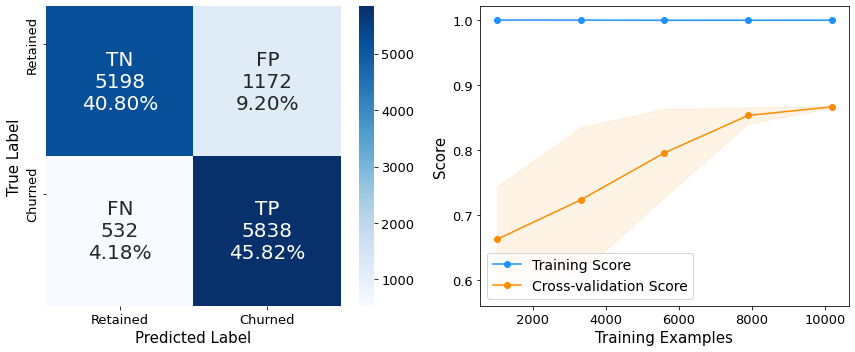

In [144]:
knn = KNeighborsClassifier( )

param_grid = [{'n_neighbors': range(1, 15),
                'p':[1,2]}]

knn_clf = GridSearchCV(estimator = knn,
                        param_grid = param_grid,
                        cv = 5,
                        n_jobs = -1)
                        
best_knn_clf = knn_clf.fit(X_train, y_train)
clf_performance(best_knn_clf, 'K Nearest Neighbours', 'KNN')

#### Logistic Regression


 Logistic Regression
-------------------------------
   Best Score (recall):  0.743
   Best Parameters: 
C: 0.001
max_iter: 100
penalty: l1
solver: liblinear


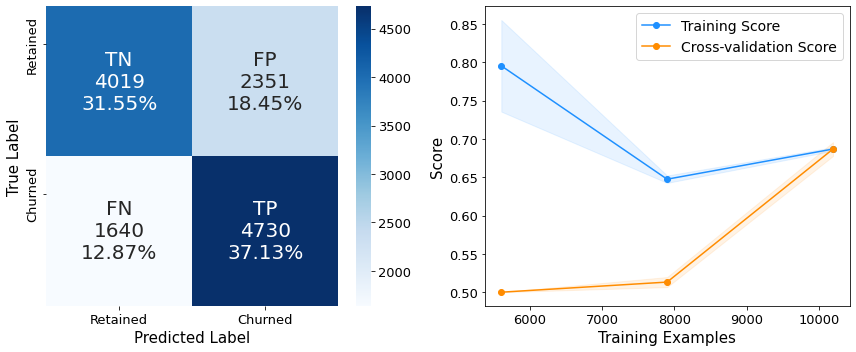

In [145]:
lr = LogisticRegression(random_state=42)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    # C : the 1/lambda value(weight) for L1 and L2
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    # # solver: algorithm to find the weights that minimize the cost function
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

#### Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (recall):  0.805
   Best Parameters: 
C: 10
gamma: scale
kernel: rbf


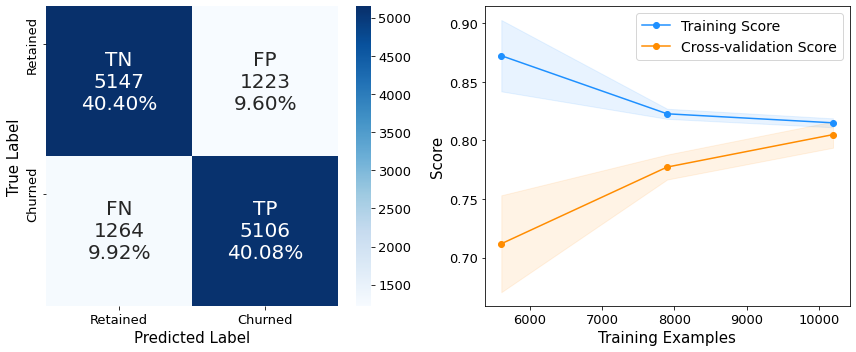

In [146]:
svc = SVC(probability= True, random_state= 42)

param_grid = [{'kernel':['rbf','linear'],
                'gamma':['scale','auto'], # can also tune with [0.0001, 0.0005, 0.001, 0.005]
                'C':[.1, 1, 10]}]

svc_clf = GridSearchCV(estimator = svc,
                        param_grid = param_grid,
                        cv = 5,
                        n_jobs = -1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

#### Random Forest Classifier


 Random Forest
-------------------------------
   Best Score (recall):  0.782
   Best Parameters: 
bootstrap: False
criterion: gini
max_depth: 6
max_features: log2
min_samples_leaf: 2
min_samples_split: 2
n_estimators: 100


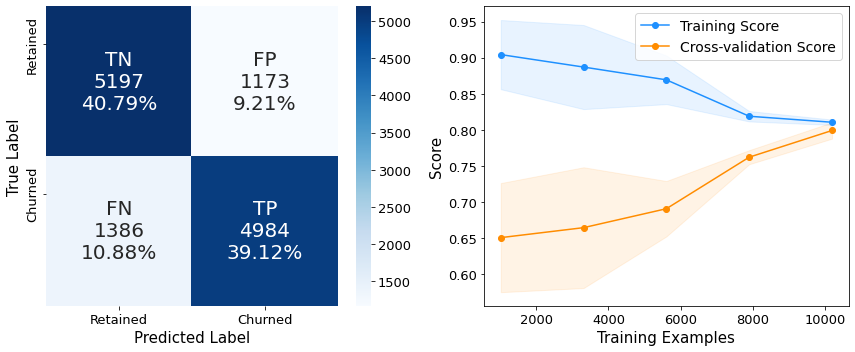

In [147]:
rf = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['log2', 'sqrt'],f
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

#### Gradient Boosting Classifier


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall):  0.778
   Best Parameters: 
learning_rate: 0.01
max_depth: 3
max_features: auto
min_samples_leaf: 5
min_samples_split: 5
n_estimators: 600
n_iter_no_change: 20
subsample: 0.66
tol: 0.01
validation_fraction: 0.2


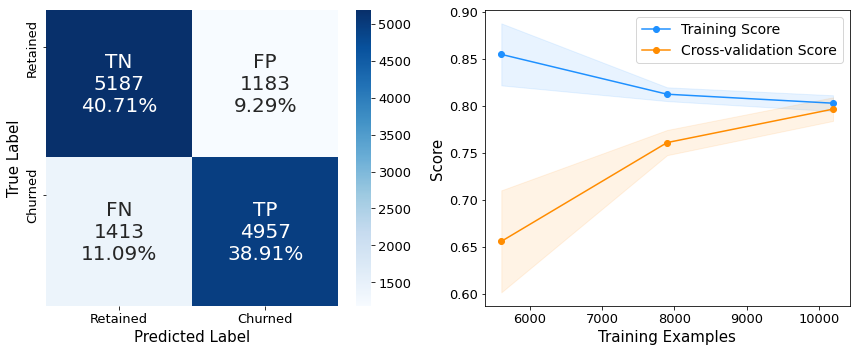

In [148]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

#### Ensemble Learning 
We can combine the predictions of all these classifiers to determine if we get better predictive performance compared to each individual constituent classifier. This practice is the main motivation behind Ensemble Learning.

Specifically, I will use __*Soft Voting*__. In this case, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.


Soft Voting
-----------------
  Recall:  0.806


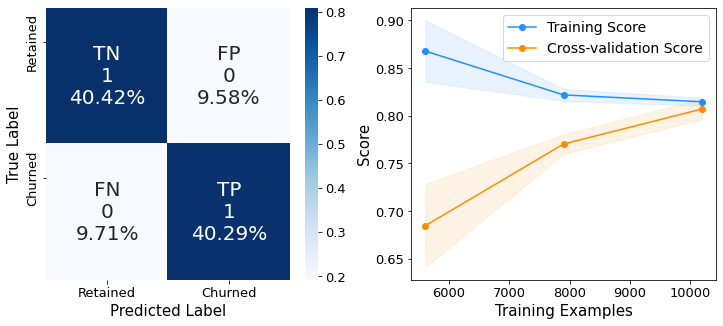

In [149]:
estimators = [('KNN',best_knn_clf.best_estimator_),
              ('LR',best_lr_clf.best_estimator_),
              ('SCV',best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators = estimators[1:],
                                     voting = 'soft',
                                     n_jobs = -1,
                                     )

estimators.append({'SoftV':tuned_voting_soft})   

# since the soft voting method do not have the `best_param` method, here I manually write the following 
y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

### 3.3 Model Performance Discussion

#### 3.3.1 Feature Importance 

The feature importance can be easily visualized as below.

In [150]:
def plot_feature_imp ( classifier, classifier_name, color, ax):
    """
    Plot the importance of features for a classifier as a barplot. 
    """
    importances = pd.DataFrame ({'Feature':X_train.columns, 
                                'Importance':np.round(
                                    classifier.best_estimator_.feature_importances_,3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                            legend = True,
                            ax = ax)

    ax.set_title(classifier_name)     
    ax.set_xlabel('Importance')                          
   

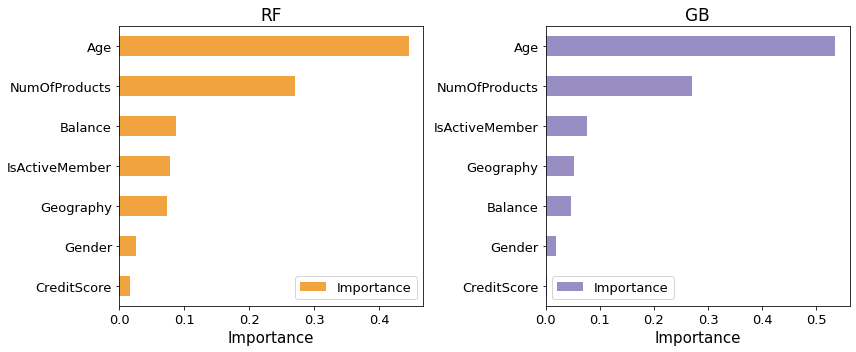

In [151]:
colors_fi = ['#f1a340','#998ec3']

fig = plt.subplots(1,2, figsize = (12,5))

for i, (name, clf) in enumerate(zip(['RF','GB'],[best_rf_clf, best_gbc_clf])):
    ax = plt.subplot(1, 2, i+1)
    plot_feature_imp(clf,name,colors_fi[i],ax)
    plt.ylabel('')

plt.tight_layout()

`Age` and `NumOfProducts` seem like the most useful features for all classifiers, followed by `IsActiveMember` and `Balance`. On the other hand, `CreditScore` is the least important feature with a small value close to zero

#### 3.3.2 Perfromance Comparison

In [152]:
comparison_matrix = {}
# use the comparision_dict defined in the SoftV valuation
for key,value in comparison_dict.items():
    comparison_matrix[str(key)] = value [0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                            index = ['Accuracy','Precision','Recall','AUC']).T
comparison_df.style.highlight_max(color = 'indianred',axis = 0)

,Accuracy,Precision,Recall,AUC
KNN,0.866248,0.832810,0.916484,0.866248
LR,0.686735,0.667985,0.742543,0.735886
SVC,0.804788,0.806763,0.801570,0.883159
RF,0.799137,0.809485,0.782418,0.883179
GBC,0.796232,0.807329,0.778179,0.877642
SVot,0.807143,0.807965,0.805808,0.886596


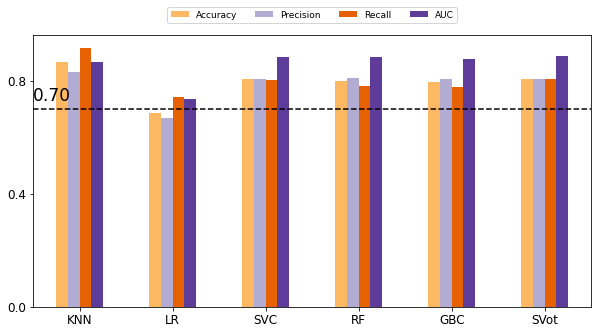

In [153]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#fdb863', '#b2abd2', '#e66101', '#5e3c99'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='black', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='black');

All the classifier other than logistic regression have a higher than 70% recall (baseline performance). And since KNN model shows the overfitting, we would not include it into the discussion. Therefore, the soft vote model has the best overall performance with highest accuracy, precision, recall and AUC.

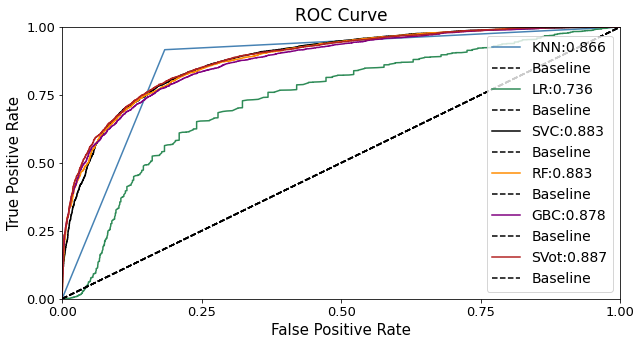

In [154]:
fig, ax = plt.subplots(figsize = (10,5))

# draw the Receiver Operator Characteristic(ROC) graphs
for index,key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4],comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color = colors_comp[index],
            label = '{}:{}'.format(key, np.round(auc,3)))

    ax.plot([0,1],[0,1],'k--', label = 'Baseline')
    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.autoscale(axis='both', tight=True)
    ax.legend(fontsize=14);


As the dashed diagonal line represents the purely random classifier, all the classifiers in our case positied toward the top-left corner of plot, and the AUC shows that SVot has a slightly higher performance. 

### 3.4 Evaluating the Test Set

Now is the time to evaluate the models on unseen data. First, we need to perform the same preprocessing steps as the training set.

In [155]:
test_df = test_df.drop(features_drop, axis=1)

test_df['Gender'] = LabelEncoder().fit_transform(test_df['Gender'])
test_df['Geography'] = test_df['Geography'].map({
    'Germany': 1,
    'Spain': 0,
    'France': 0
})

test_df[scl_columns] = scaler.transform(test_df[scl_columns])  # not fit_transform, scaler has already been trained

y_test = test_df['Exited']
X_test = test_df.drop('Exited', 1)

In [156]:
# using the same method for comparing the classifier as we did in the training set
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentage = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for
                 v1,v2,v3 in zip(group_names, group_counts, group_percentage)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(data = cm, # get the percentage of data is represented in each quadrant
                annot = labels,
                fmt = '',
                cmap = 'Blues',
                annot_kws = {'fontsize':10},
                ax = ax)

    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned'])

In [114]:
tuned_voting_soft.fit(X_train, y_train)

for i, (name, clf) in enumerate(zip(['LR','KNN' ,'SVC', 'RF', 'GB',  'SVot'], 
                                    [best_lr_clf.best_estimator_, best_knn_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, tuned_voting_soft])):
    y_pred = clf.predict(X_test)

    comparison_test_dict[name] = [accuracy_score(y_test, y_pred),
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]

comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall
LR,0.665000,0.351076,0.761671
KNN,0.762000,0.436697,0.584767
SVC,0.791000,0.491366,0.769042
RF,0.796500,0.500000,0.754300
GB,0.801000,0.507614,0.737101
SVot,0.798000,0.502400,0.771499


The performance on the test set for all models is fairly similar to the training set, expect that KNN performed poorly on the test set. Therefore we would still regard SVot as our optimal model, that can predict the bank customer churn with a recall of 77.15%.

# Part 4: Conclusions and Future Improvements

### Conclusions

- With the *__EDA__* and the __*feature importance*__ calculation, our quantified methods delivers information about of all the available features, `age` (older customers have higher chance to churn) and `number of products` (possessing more products increases the chance to churn) contributes most to the prediction. <br><br>
    - Business Application
        - Provide targeting bonus or promotion towards seniors.
        - Apply more attentative care and customer service for people having more products.
<br><br>
- The machine learning model **_SVot_** that we deployed  has a recall of _**78%**_, suggesting that for all the customers that are classified as about the churn, we can correctly detect 80% of the cases. 

### Future Improvements

- The overfitting pattern of the KNN model should be delt with.
- Feature engineering could potentially improve the model performance. 